In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import regex as re
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, auc, roc_curve, roc_auc_score, balanced_accuracy_score, classification_report, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore")


In [2]:
df_raw = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
description = pd.read_excel("data_dictionary.xlsx")
pd.set_option('display.max_column', None)

In [3]:
df_raw.sample(20)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,DISBURSAL_DATE,STATE_ID,EMPLOYEE_CODE_ID,MOBILENO_AVL_FLAG,AADHAR_FLAG,PAN_FLAG,VOTERID_FLAG,DRIVING_FLAG,PASSPORT_FLAG,PERFORM_CNS_SCORE,PERFORM_CNS_SCORE_DESCRIPTION,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
120845,487048,73613,112858,66.45,2,22574,51,1732,01-01-1994,Self employed,03-09-2018,4,1181,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
148998,571777,45849,61921,75.10,3,14078,45,49,04-12-1981,Self employed,12-10-2018,1,1968,1,1,0,0,0,0,625,H-Medium Risk,3,2,0,205830,400000,402306,1,0,1,0,0,0,0,0,0,1,0yrs 10mon,1yrs 10mon,1,0
141792,507244,44849,64064,71.02,207,23546,86,892,13-06-1978,Self employed,14-09-2018,6,511,1,1,0,0,0,0,845,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1yrs 7mon,1yrs 9mon,0,0
215593,451384,57259,64780,89.53,146,18473,86,3000,01-01-1981,Self employed,20-08-2018,14,3089,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
45430,575553,57999,80079,74.68,7,23717,45,5740,28-07-1991,Salaried,13-10-2018,3,1035,1,1,0,0,0,0,15,Not Scored: Sufficient History Not Available,1,1,0,15500,15500,15500,0,0,0,0,0,0,0,0,1,0,0yrs 1mon,0yrs 1mon,0,0
65850,557503,60013,74500,81.61,248,14791,86,1796,31-12-1972,Self employed,04-10-2018,4,63,1,1,0,0,0,0,738,C-Very Low Risk,3,2,0,27052,48990,48990,0,0,0,0,0,0,0,0,2,0,0yrs 7mon,1yrs 4mon,0,0
155088,504254,51403,60423,86.89,15,14300,45,303,01-07-1993,Salaried,14-09-2018,11,2050,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
6597,631008,55013,77852,73.22,29,23200,49,5865,12-10-1980,Self employed,27-10-2018,3,1438,1,1,0,0,0,0,15,Not Scored: Sufficient History Not Available,8,4,0,177610,206840,206840,0,0,0,0,0,0,20959,0,4,0,0yrs 7mon,1yrs 2mon,1,0
191454,600695,48558,62029,82.22,79,21445,86,772,01-01-1983,Salaried,22-10-2018,18,2499,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
166901,516936,65882,98472,69.06,159,23136,51,7186,17-03-1996,Salaried,19-09-2018,7,2279,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [4]:
# Lowercase all columns name because i like to
df_raw.columns = df_raw.columns.str.lower()

In [5]:
target = 'loan_default'
drop_irre_cols = []
release_date = date(2019, 11, 12)

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   uniqueid                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   current_pincode_id                   233154 non-null  int64  
 8   date_of_birth                        233154 non-null  object 
 9   employment_type                      225493 non-null  object 
 10  disbursal_date                       233154 non-null  object 
 11  state_id     

In [102]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
uniqueid,233154.0,535917.573376,6.831569e+04,417428.00,476786.25,535978.5,595039.75,6.710840e+05
disbursed_amount,233154.0,54356.993528,1.297131e+04,13320.00,47145.00,53803.0,60413.00,9.905720e+05
asset_cost,233154.0,75865.068144,1.894478e+04,37000.00,65717.00,70946.0,79201.75,1.628992e+06
ltv,233154.0,74.746530,1.145664e+01,10.03,68.88,76.8,83.67,9.500000e+01
branch_id,233154.0,72.936094,6.983499e+01,1.00,14.00,61.0,130.00,2.610000e+02
supplier_id,233154.0,19638.635035,3.491950e+03,10524.00,16535.00,20333.0,23000.00,2.480300e+04
manufacturer_id,233154.0,69.028054,2.214130e+01,45.00,48.00,86.0,86.00,1.560000e+02
current_pincode_id,233154.0,3396.880247,2.238148e+03,1.00,1511.00,2970.0,5677.00,7.345000e+03
state_id,233154.0,7.262243,4.482230e+00,1.00,4.00,6.0,10.00,2.200000e+01
employee_code_id,233154.0,1549.477148,9.752613e+02,1.00,713.00,1451.0,2362.00,3.795000e+03


In [7]:
### EDA functions

def nunique_df(df):
    nunique_df = df.nunique().reset_index().rename(columns={
        'index': 'Name',
        0: 'NumberOfUnique'
    })
    return nunique_df

def missing_data_df(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).reset_index().rename(columns ={'index':'Name'})

In [138]:
### FE functions

def format_datetime(df, col):
    df[col] = pd.to_datetime(df[col])
    print(f'{col} dtype:', df[col].dtype)

def calculate_age(born):
    release_date = date(2019, 11, 12)
    return release_date.year - born.year - ((release_date.month, release_date.day) < (born.month, born.day))

def calculate_disbursal_age(x):
    release_date = date(2019, 11, 12)
    return x - pd.to_datetime(release_date).days

def standard_scaler(df, col):
    scaler = StandardScaler()
    df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])

def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

### NaN occurs when age is 19, 20, 64... -> young and old age = Unemployed
def impute_employment_type(df):
    df['employment_type'].fillna(value='Unemployed', inplace = True)

In [9]:
### Outliers treatment function
def outlier_fix(df, col):
    print('Fixing:', col)
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    print('Quartile 1 =', q1)
    print('Quartile 3 =', q3)
    print('Inter Quartile Range =', iqr)
    print('Low =', low)
    print('High =', high)
    df.loc[df[col] < low, col] = low
    df.loc[df[col] > high, col] = high

In [10]:
### Feature Selection functions
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

def identify_distinct_value(df, threshold):
    cols = df.columns
    feature_to_drop = []
    for col in cols:
        highest_percent_distinct = df[col].value_counts(normalize = True).values[0]
        if highest_percent_distinct >= threshold:
            feature_to_drop.append(col)
    return feature_to_drop

In [11]:
### Optimize Dataset
def optimize_mem(df, verbose=True):
    start_memory = df.memory_usage().sum() / 1024**2
    exclude_datetime = df.drop(columns=['date_of_birth', 'disbursal_date', 'employment_type']).columns
    for col in exclude_datetime:
        col_type = df[col].dtype

        if col_type != object:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(
                        np.int8).max:  # check self.df type compatibility
                    df[col] = df[col].astype(
                        np.int8)  # change self.df type per condition
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
             df[col] = df[col].astype('category')
    end_memory = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_memory, 100 * (start_memory - end_memory) /
        start_memory)) if verbose else print(
            'Reduced to {:5.2f}'.format(end_memory))
    return 'Maximize dataset complete'

In [12]:
### Plot functions

def plot_pie(df, col, label = None):
    df.groupby([col]).size().plot(
    kind = 'pie',
    figsize = (12,8),
    labels = label,
    autopct='%1.1f%%',
#    explode = [0.15, 0],
    startangle=90,     
    shadow=True, 
    colors = ['#008eff', '#ff0028']
    )
    plt.title('Distribution of TARGET')
    plt.axis('equal')
    plt.show()

def plot_dist_hue(df, col, target = target):
    t1 = df.loc[
    (df[target] == 1) &
    (df[col]),
    [col]
    ]
    t0 = df.loc[
    (df[target] == 0) &
    (df[col])
                
    ]
    sns.set_style('whitegrid')
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,8))
    sns.distplot(df[col], color = 'orange', ax= ax1)

    ax2.boxplot(df[col], patch_artist=True, vert=False)

    sns.kdeplot(t1[col], bw=0.5,label="Defaulter")
    sns.kdeplot(t0[col], bw=0.5,label="Non-Defaulter")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(f'{col}', fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend()
    plt.show()


def plot_cat(df, col, target = target):
    sns.countplot(x = df[df[target] == 1][col], palette='hot').set(title = 'Defaulter')


def plot_model_evaluation(model, X_test, y_test):
    predicted_probas = model.predict_proba(X_test)
    skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

    skplt.metrics.plot_lift_curve(y_true=y_test, y_probas=predicted_probas)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    fpr , tpr , thresholds = roc_curve(y_test,predicted_probas[:,1])
    ax.plot(fpr,tpr,label = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE and AREA UNDER CURVE")
    ax.set_facecolor("k")
    plt.show()



In [13]:
### Evalation functions
def model_evaluation(X_train, y_train, model):
    kfold = KFold(n_splits=5, shuffle=True)
    # enumerate splits
    scores = []
    for train_ix, test_ix in kfold.split(X_train):
        train_X, test_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
        train_y, test_y = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # fit model
        model_ = model
        model_.fit(train_X, train_y)
    # evaluate model
        yhat = [item[1] for item in model_.predict_proba(test_X)]
        auc_score = roc_auc_score(test_y, yhat)
    # store score
        scores.append(auc_score)
        print('> ', auc_score)
    # summarize model performance
    mean_s, std_s = np.mean(scores), np.std(scores)
    print('Mean: %.3f, Standard Deviation: %.3f' % (mean_s, std_s))

In [14]:
df_copy = df_raw.copy()
for col in ['date_of_birth', 'disbursal_date']:
    format_datetime(df_copy, col)

date_of_birth dtype: datetime64[ns]
disbursal_date dtype: datetime64[ns]


In [15]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
uniqueid,233154.0,535917.573376,6.831569e+04,417428.00,476786.25,535978.5,595039.75,6.710840e+05
disbursed_amount,233154.0,54356.993528,1.297131e+04,13320.00,47145.00,53803.0,60413.00,9.905720e+05
asset_cost,233154.0,75865.068144,1.894478e+04,37000.00,65717.00,70946.0,79201.75,1.628992e+06
ltv,233154.0,74.746530,1.145664e+01,10.03,68.88,76.8,83.67,9.500000e+01
branch_id,233154.0,72.936094,6.983499e+01,1.00,14.00,61.0,130.00,2.610000e+02
supplier_id,233154.0,19638.635035,3.491950e+03,10524.00,16535.00,20333.0,23000.00,2.480300e+04
manufacturer_id,233154.0,69.028054,2.214130e+01,45.00,48.00,86.0,86.00,1.560000e+02
current_pincode_id,233154.0,3396.880247,2.238148e+03,1.00,1511.00,2970.0,5677.00,7.345000e+03
state_id,233154.0,7.262243,4.482230e+00,1.00,4.00,6.0,10.00,2.200000e+01
employee_code_id,233154.0,1549.477148,9.752613e+02,1.00,713.00,1451.0,2362.00,3.795000e+03


In [16]:
missing_data_df(df_raw)

,Name,Total,Percent
0,employment_type,7661,3.285811
1,uniqueid,0,0.000000
2,sec_sanctioned_amount,0,0.000000
3,pri_overdue_accts,0,0.000000
4,pri_current_balance,0,0.000000
5,pri_sanctioned_amount,0,0.000000
6,pri_disbursed_amount,0,0.000000
7,sec_no_of_accts,0,0.000000
8,sec_active_accts,0,0.000000
9,sec_overdue_accts,0,0.000000


In [17]:
nunique_df(df_raw)

,Name,NumberOfUnique
0,uniqueid,233154
1,disbursed_amount,24565
2,asset_cost,46252
3,ltv,6579
4,branch_id,82
5,supplier_id,2953
6,manufacturer_id,11
7,current_pincode_id,6698
8,date_of_birth,15433
9,employment_type,2


In [18]:
drop_irre_cols.extend(identify_correlated(df_raw, 0.8))

In [19]:
num_cols = df_raw.select_dtypes(include='number')
tmp = identify_distinct_value(df_raw, 0.8)
drop_irre_cols.extend(tmp)

In [136]:
len(identify_correlated(df_raw, 0.8))

5

In [20]:
### mobileno_avl_flag only have one value so drop
drop_irre_cols.append('uniqueid')

In [142]:
df_copy

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursal_date,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,age,disbursal_age,perform_cns_score_description_group,average_acct_y,average_acct_m,credit_history__y,credit_history__m
0,420825,50578,58400,89.56250,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35,-614,N,0,0,0,0
1,537409,47145,65550,73.25000,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,34,-412,I,1,23,1,23
2,417566,53278,61360,89.62500,67,22807,45,1497,1985-08-24,Self employed,2018-01-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,34,-673,N,0,0,0,0
3,624493,57513,66113,88.50000,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,25,-382,L,0,8,1,15
4,539055,52378,60300,88.37500,67,22807,45,1495,1977-09-12,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,42,-412,N,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.71875,34,20700,48,1050,1988-01-08,Salaried,2018-10-26,6,3705,1,0,0,1,0,0,735,D-Very Low Risk,4,3,0,390443,416133,416133,0,0,0,0,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0,31,-382,D,1,21,3,39
233150,606141,73651,100600,74.93750,34,23775,51,990,1988-05-12,Self employed,2018-10-23,6,3705,1,0,0,1,0,0,825,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0,31,-385,A,0,6,0,6
233151,613658,33484,71212,48.43750,77,22186,86,2299,1976-01-06,Salaried,2018-10-24,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,43,-384,N,0,0,0,0
233152,548084,34259,73286,49.09375,77,22186,86,2299,1994-03-26,Salaried,2018-09-29,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,25,-409,N,0,0,0,0


In [22]:
df_copy['age'] = df_copy['date_of_birth'].apply(calculate_age)
drop_irre_cols.append('date_of_birth')

In [23]:
df_copy['disbursal_age'] = df_copy['disbursal_date'].apply(lambda x: (x - pd.to_datetime(release_date)).days)
drop_irre_cols.append('disbursal_date')

In [24]:
### Group all Not scorced and No bureau history to a single class N
df_copy['perform_cns_score_description_group'] = df_copy.perform_cns_score_description.str[0]
drop_irre_cols.append('perform_cns_score_description')

In [25]:
df_copy

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursal_date,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,age,disbursal_age,perform_cns_score_description_group
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35,-614,N
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,34,-412,I
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,2018-01-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,34,-673,N
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,25,-382,L
4,539055,52378,60300,88.39,67,22807,45,1495,1977-09-12,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,42,-412,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,34,20700,48,1050,1988-01-08,Salaried,2018-10-26,6,3705,1,0,0,1,0,0,735,D-Very Low Risk,4,3,0,390443,416133,416133,0,0,0,0,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0,31,-382,D
233150,606141,73651,100600,74.95,34,23775,51,990,1988-05-12,Self employed,2018-10-23,6,3705,1,0,0,1,0,0,825,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0,31,-385,A
233151,613658,33484,71212,48.45,77,22186,86,2299,1976-01-06,Salaried,2018-10-24,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,43,-384,N
233152,548084,34259,73286,49.10,77,22186,86,2299,1994-03-26,Salaried,2018-09-29,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,25,-409,N


In [26]:
df_copy[['average_acct_y', 'average_acct_m']] = df_copy['average_acct_age'].str.split(' ', expand=True)

In [27]:
df_copy[['credit_history__y', 'credit_history__m']] = df_copy['credit_history_length'].str.split(' ', expand=True)

In [28]:
df_copy['average_acct_y'] = df_copy['average_acct_y'].str.replace(r'\D', '').astype(int)
df_copy['average_acct_m'] = df_copy['average_acct_m'].str.replace(r'\D', '').astype(int)
df_copy['credit_history__m'] = df_copy['credit_history__m'].str.replace(r'\D', '').astype(int)
df_copy['credit_history__y'] = df_copy['credit_history__y'].str.replace(r'\D', '').astype(int)

In [29]:
df_copy['average_acct_m'] = df_copy['average_acct_y'] * 12 + df_copy['average_acct_m']
df_copy['credit_history__m'] = df_copy['credit_history__y'] * 12 + df_copy['credit_history__m']

In [30]:
drop_irre_cols.extend(['credit_history__y', 'average_acct_y', 'average_acct_age', 'credit_history_length'])

In [31]:
df_copy

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursal_date,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,age,disbursal_age,perform_cns_score_description_group,average_acct_y,average_acct_m,credit_history__y,credit_history__m
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-03-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35,-614,N,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,34,-412,I,1,23,1,23
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,2018-01-08,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,34,-673,N,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,25,-382,L,0,8,1,15
4,539055,52378,60300,88.39,67,22807,45,1495,1977-09-12,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,42,-412,N,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,626432,63213,105405,60.72,34,20700,48,1050,1988-01-08,Salaried,2018-10-26,6,3705,1,0,0,1,0,0,735,D-Very Low Risk,4,3,0,390443,416133,416133,0,0,0,0,0,0,4084,0,0,0,1yrs 9mon,3yrs 3mon,0,0,31,-382,D,1,21,3,39
233150,606141,73651,100600,74.95,34,23775,51,990,1988-05-12,Self employed,2018-10-23,6,3705,1,0,0,1,0,0,825,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,1565,0,0,0,0yrs 6mon,0yrs 6mon,0,0,31,-385,A,0,6,0,6
233151,613658,33484,71212,48.45,77,22186,86,2299,1976-01-06,Salaried,2018-10-24,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,43,-384,N,0,0,0,0
233152,548084,34259,73286,49.10,77,22186,86,2299,1994-03-26,Salaried,2018-09-29,4,3479,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,25,-409,N,0,0,0,0


In [32]:
impute_employment_type(df_copy)

In [33]:
df_copy.isnull().sum().sum()

0

In [34]:
df_copy[df_copy['employment_type'] == 'Unemployed'].sample(20)

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursal_date,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,age,disbursal_age,perform_cns_score_description_group,average_acct_y,average_acct_m,credit_history__y,credit_history__m
197224,527546,44394,70401,63.92,147,17705,45,2795,1999-09-13,Unemployed,2018-09-22,2,2726,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,20,-416,N,0,0,0,0
37422,601393,67982,83500,83.83,8,23634,51,5331,1991-05-14,Unemployed,2018-10-22,3,761,1,1,0,0,0,0,738,C-Very Low Risk,5,3,0,637551,711389,711389,0,0,0,0,0,0,43567,0,2,0,0yrs 9mon,1yrs 8mon,0,0,28,-386,C,0,9,1,20
30087,651339,92070,120503,79.67,103,24393,48,6982,1998-06-08,Unemployed,2018-10-31,7,320,1,1,0,0,0,0,743,C-Very Low Risk,2,2,0,1842265,2096000,2096000,0,0,0,0,0,0,18426,0,1,0,0yrs 4mon,0yrs 8mon,0,1,21,-377,C,0,4,0,8
121169,570662,52478,80461,68.36,255,23415,45,5848,1998-12-14,Unemployed,2018-11-10,3,67,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,20,-367,N,0,0,0,0
138733,500227,56259,73000,79.45,146,15359,86,2981,1991-08-10,Unemployed,2018-11-09,14,1025,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,28,-368,N,0,0,0,0
47302,430102,57259,73648,78.75,16,21124,86,2959,1984-07-24,Unemployed,2018-09-08,14,1320,1,1,0,0,0,0,694,E-Low Risk,5,3,0,74347,95210,95210,0,0,0,0,0,0,4474,0,2,0,0yrs 7mon,1yrs 2mon,1,0,35,-430,E,0,7,1,14
3797,533608,57213,76500,77.12,16,18317,86,3013,1981-01-01,Unemployed,2018-09-25,14,1565,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,38,-413,N,0,0,0,0
108351,555808,107112,163764,68.39,8,23976,67,5579,1999-05-07,Unemployed,2018-03-10,3,569,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,2,0,20,-612,N,0,0,0,0
81540,623132,87620,112630,79.46,42,23199,86,5358,1998-10-28,Unemployed,2018-10-26,3,279,1,0,0,1,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,21,-382,N,0,0,0,0
1648,470278,51778,60058,89.41,63,16309,45,7089,1999-11-02,Unemployed,2018-08-28,10,998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,20,-441,N,0,0,0,0


In [35]:
df_copy.dtypes

uniqueid                                        int64
disbursed_amount                                int64
asset_cost                                      int64
ltv                                           float64
branch_id                                       int64
supplier_id                                     int64
manufacturer_id                                 int64
current_pincode_id                              int64
date_of_birth                          datetime64[ns]
employment_type                                object
disbursal_date                         datetime64[ns]
state_id                                        int64
employee_code_id                                int64
mobileno_avl_flag                               int64
aadhar_flag                                     int64
pan_flag                                        int64
voterid_flag                                    int64
driving_flag                                    int64
passport_flag               

In [36]:
optimize_mem(df_copy)

Mem. usage decreased to 25.81 Mb (68.5% reduction)


'Maximize dataset complete'

In [37]:
drop_for_logit = ['branch_id', 'supplier_id', 'manufacturer_id', 'current_pincode_id', 'employee_code_id', 'perform_cns_score_description_group']
drop_irre_cols.extend(drop_for_logit)

In [38]:
df_logit = df_copy.drop(columns = set(drop_irre_cols))

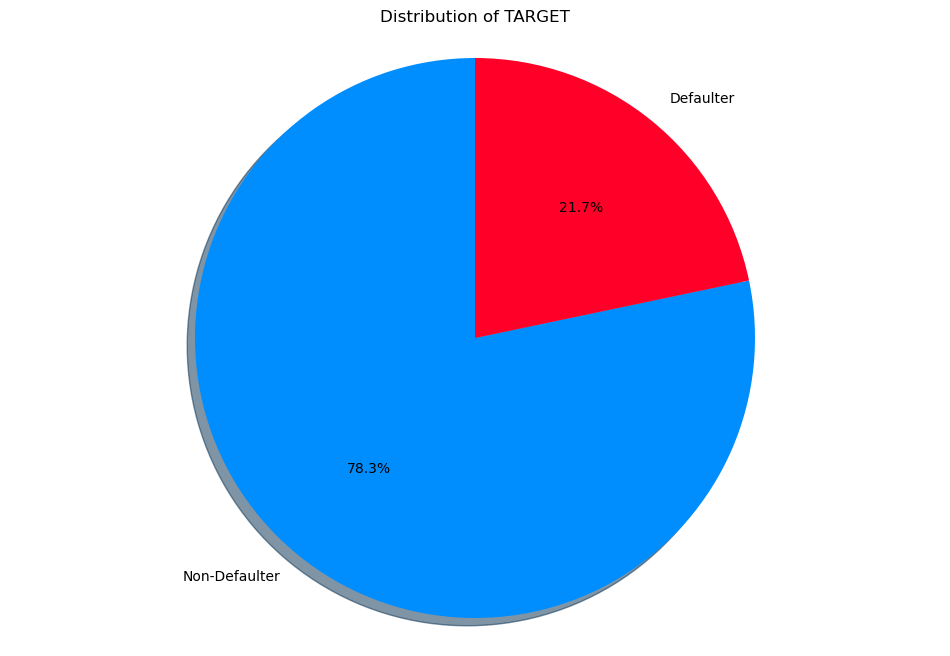

In [39]:
plot_pie(df_logit, target, label = ['Non-Defaulter', 'Defaulter'])

### Data is imbalance -> deal later

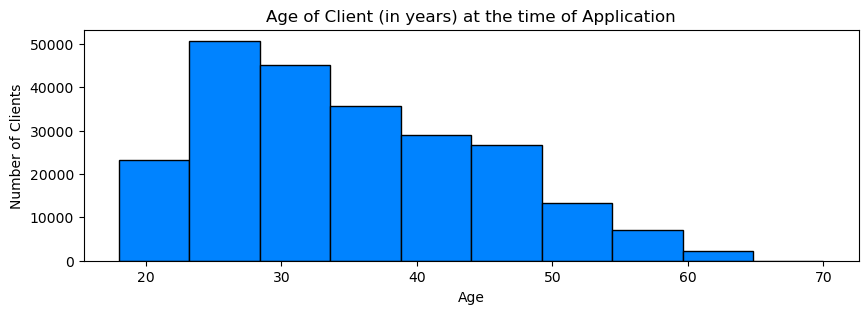

In [40]:
plt.figure(figsize=(10,3))
plt.hist(df_logit['age'], bins=10, edgecolor='black', color='#0083ff')
plt.title('Age of Client (in years) at the time of Application')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

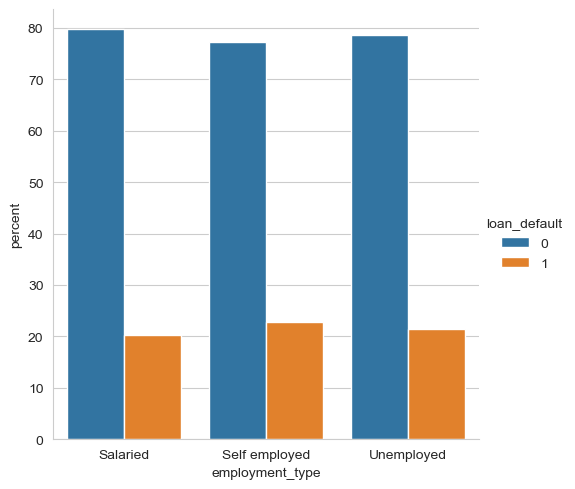

In [127]:
(df_copy.groupby('employment_type')[target].value_counts(normalize=True).mul(100).rename(
    'percent').reset_index().pipe((sns.catplot, 'data'), x='employment_type', y='percent', hue=target, kind='bar'))

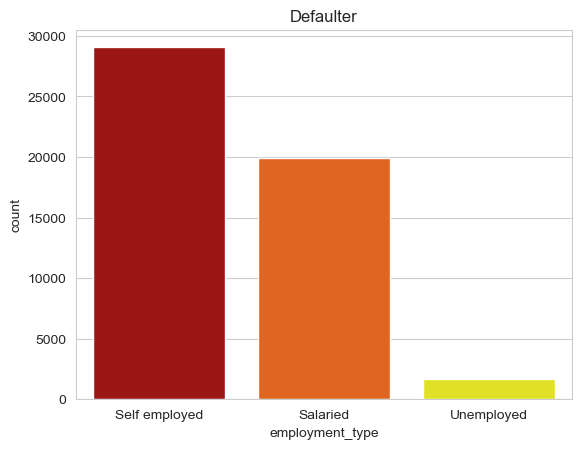

In [124]:
plot_cat(df_copy, 'employment_type')

In [42]:
cat_cols_logit = ['uniqueid', 'employment_type', 'state_id', 'loan_default']
num_cols_logit = df_logit.select_dtypes(include='number').columns.to_list()

In [43]:
num_cols_logit.remove('state_id')
num_cols_logit.remove('loan_default')

In [44]:
df_logit

,disbursed_amount,asset_cost,ltv,employment_type,state_id,perform_cns_score,pri_no_of_accts,pri_active_accts,pri_current_balance,pri_disbursed_amount,primary_instal_amt,new_accts_in_last_six_months,loan_default,age,disbursal_age,average_acct_m,credit_history__m
0,50578,58400,89.56250,Salaried,6,0,0,0,0,0,0,0,0,35,-614,0,0
1,47145,65550,73.25000,Self employed,6,598,1,1,27600,50200,1991,0,1,34,-412,23,23
2,53278,61360,89.62500,Self employed,6,0,0,0,0,0,0,0,0,34,-673,0,0
3,57513,66113,88.50000,Self employed,6,305,3,0,0,0,31,0,1,25,-382,8,15
4,52378,60300,88.37500,Self employed,6,0,0,0,0,0,0,0,1,42,-412,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,63213,105405,60.71875,Salaried,6,735,4,3,390443,416133,4084,0,0,31,-382,21,39
233150,73651,100600,74.93750,Self employed,6,825,1,0,0,0,1565,0,0,31,-385,6,6
233151,33484,71212,48.43750,Salaried,4,0,0,0,0,0,0,0,0,43,-384,0,0
233152,34259,73286,49.09375,Salaried,4,0,0,0,0,0,0,0,0,25,-409,0,0


<Figure size 640x480 with 0 Axes>

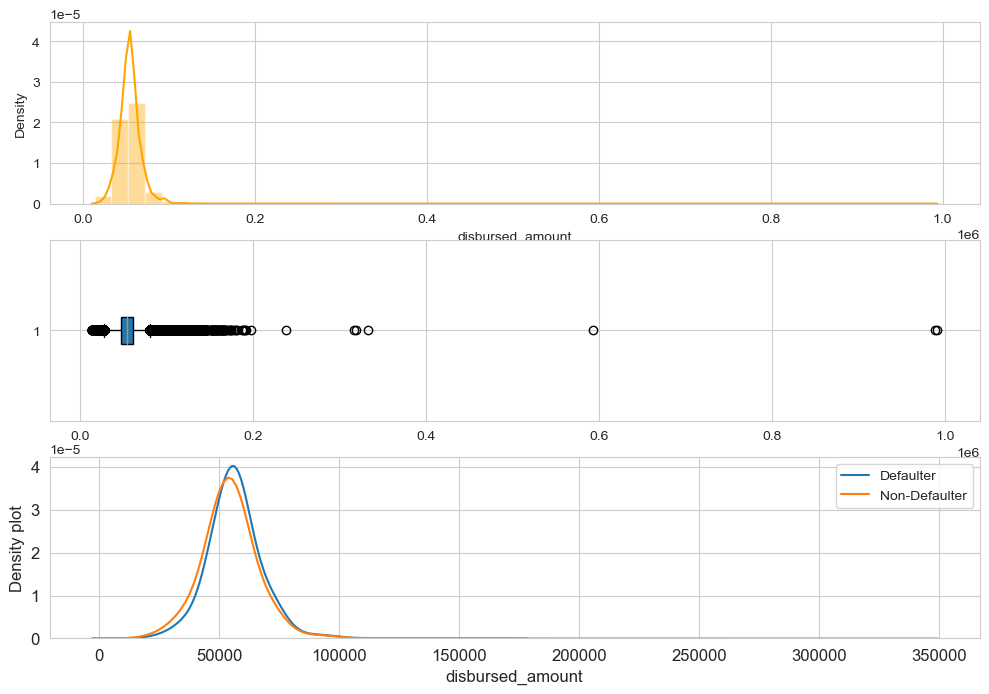

<Figure size 640x480 with 0 Axes>

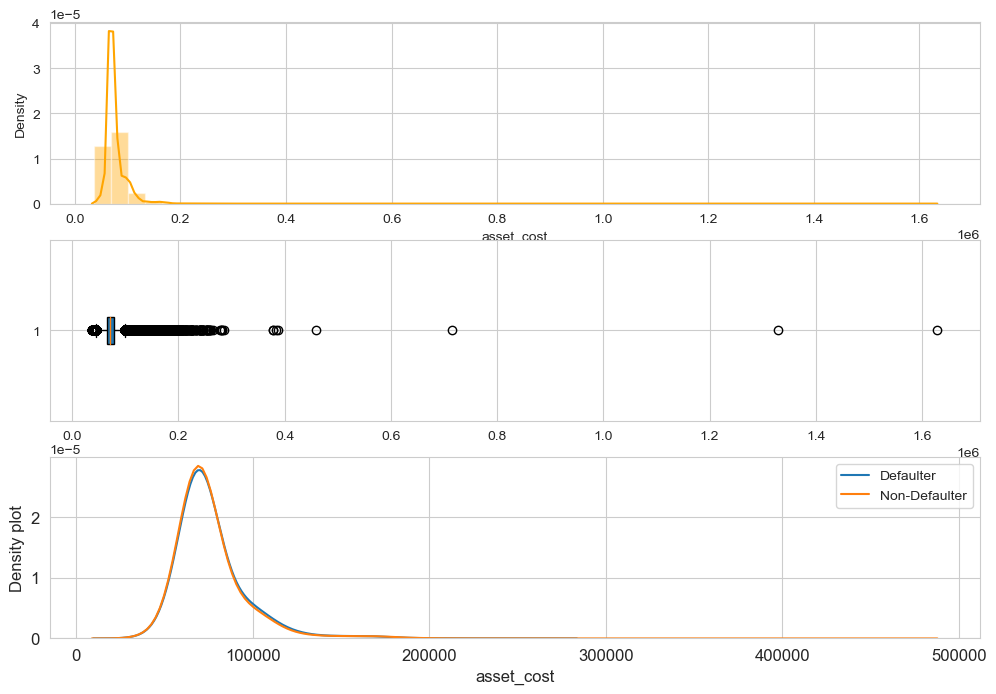

<Figure size 640x480 with 0 Axes>

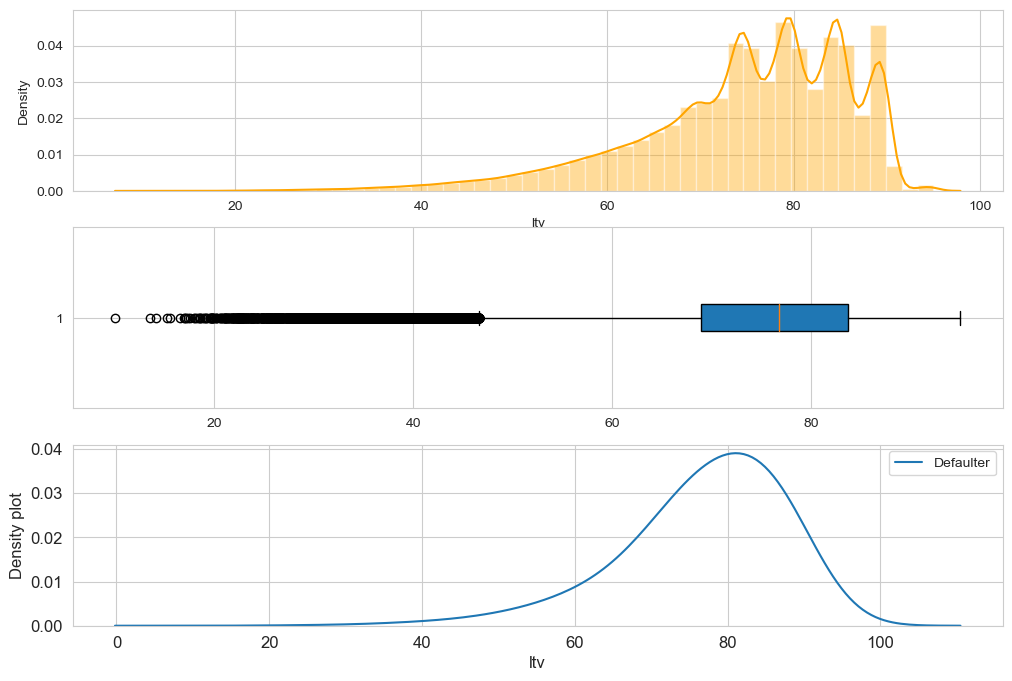

<Figure size 640x480 with 0 Axes>

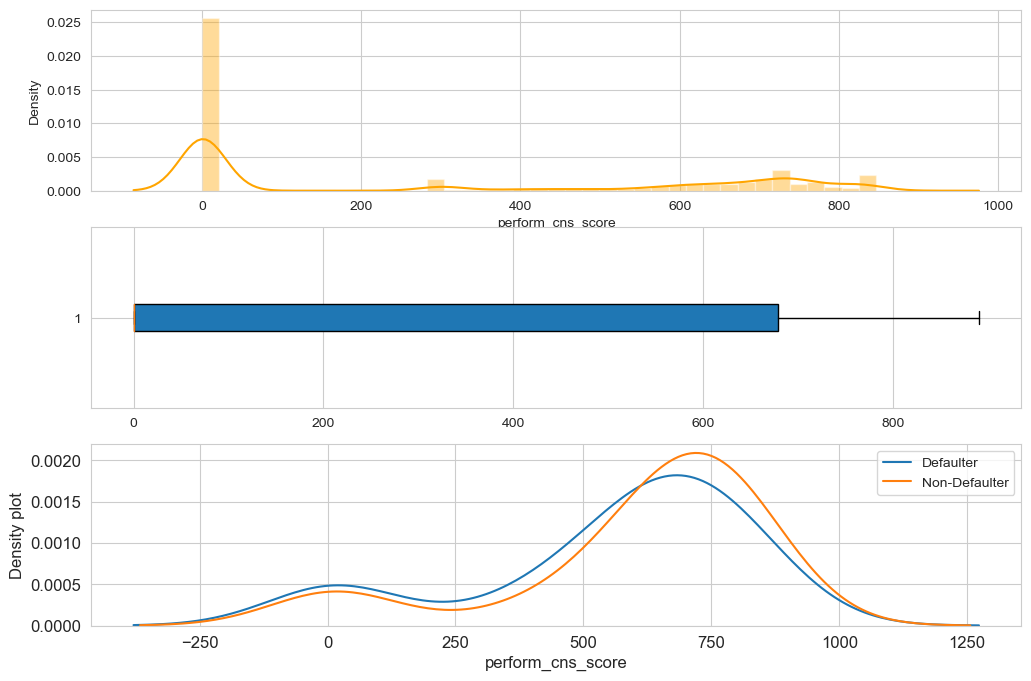

<Figure size 640x480 with 0 Axes>

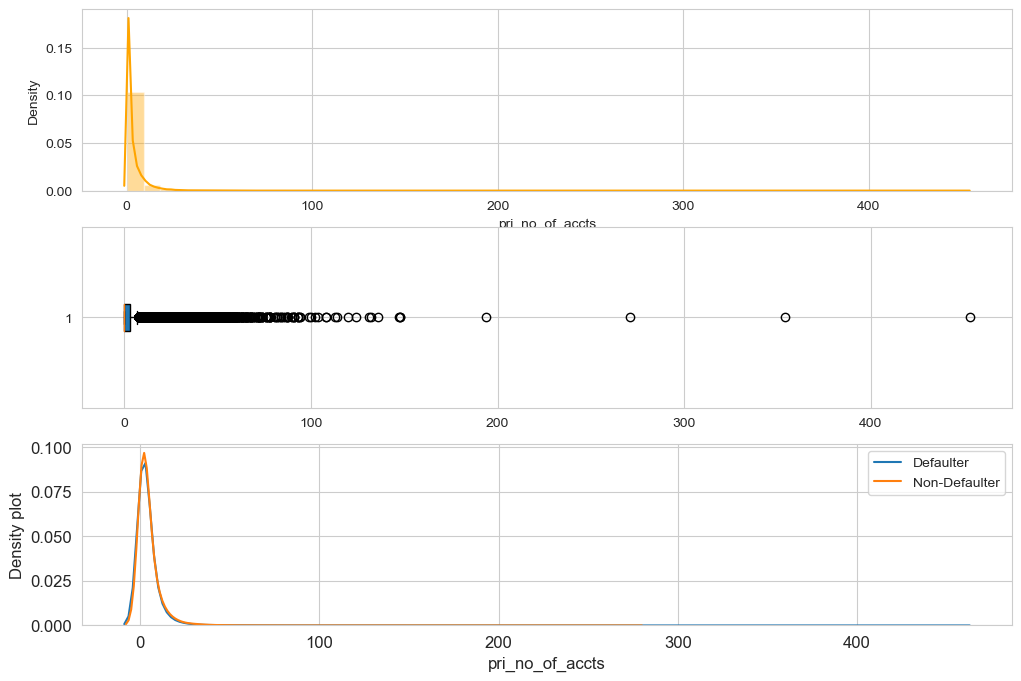

<Figure size 640x480 with 0 Axes>

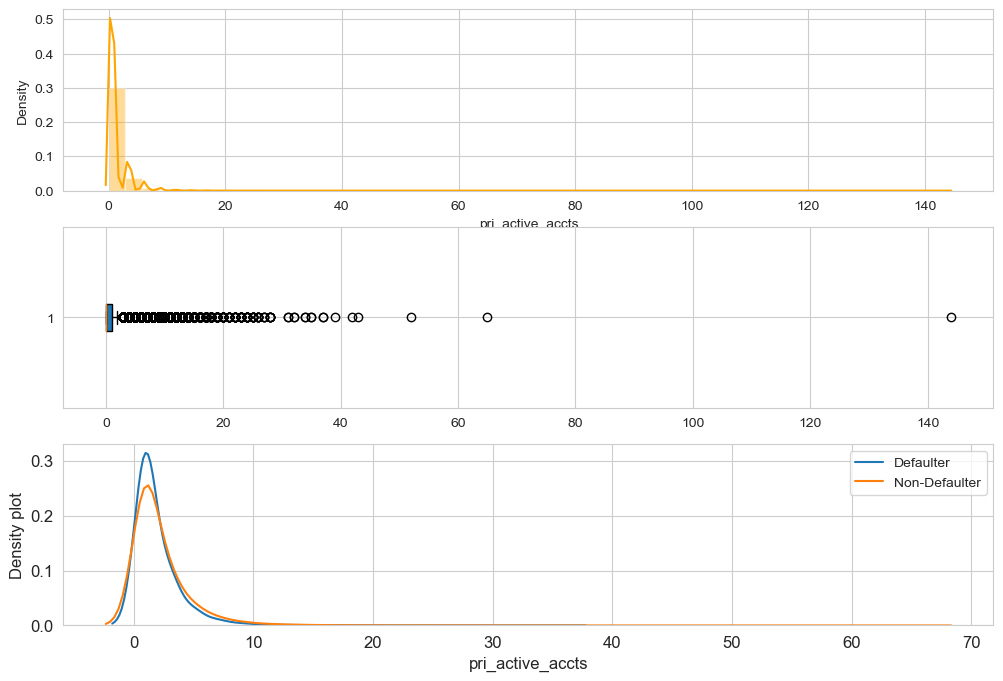

<Figure size 640x480 with 0 Axes>

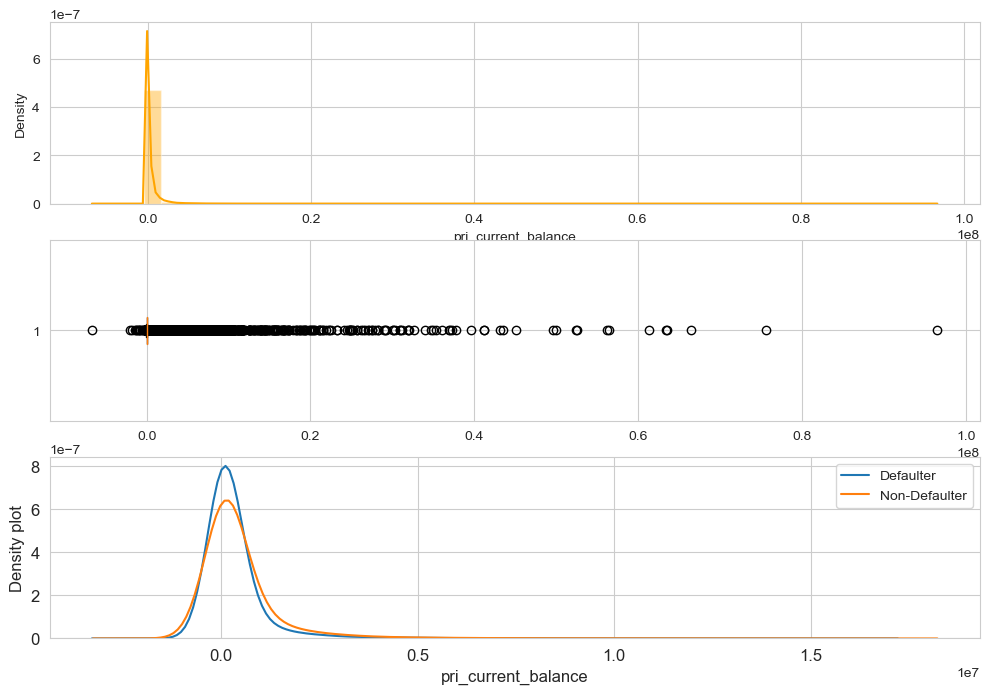

<Figure size 640x480 with 0 Axes>

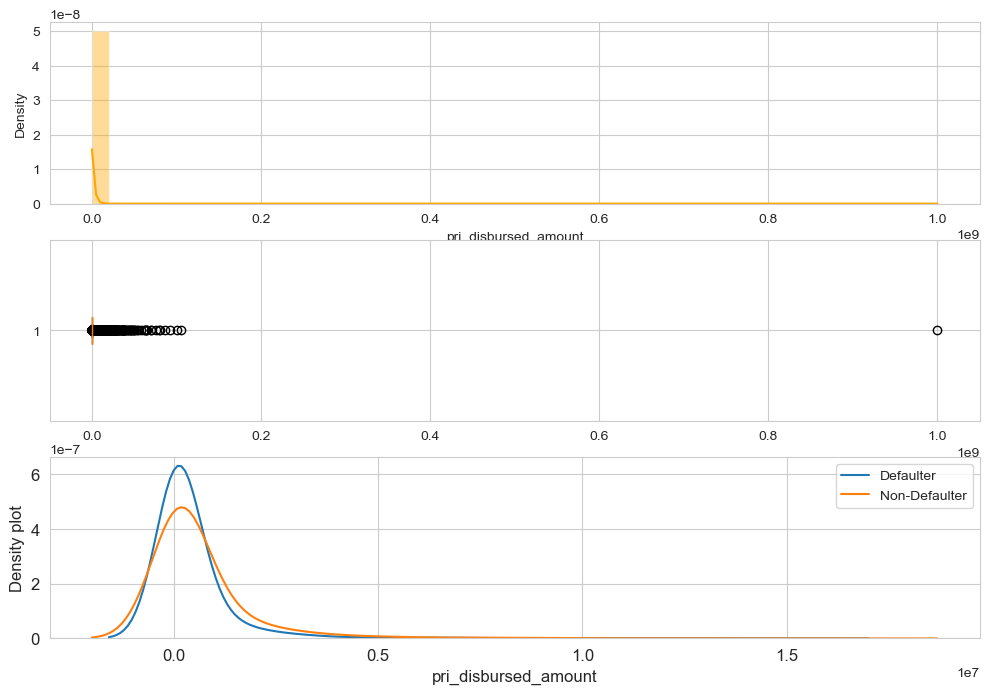

<Figure size 640x480 with 0 Axes>

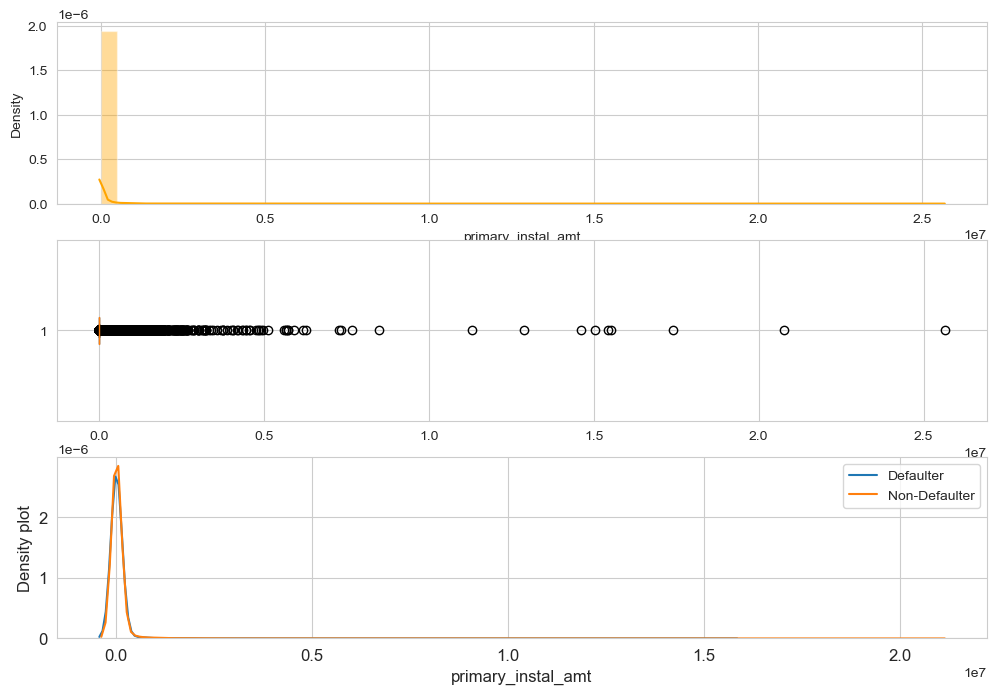

<Figure size 640x480 with 0 Axes>

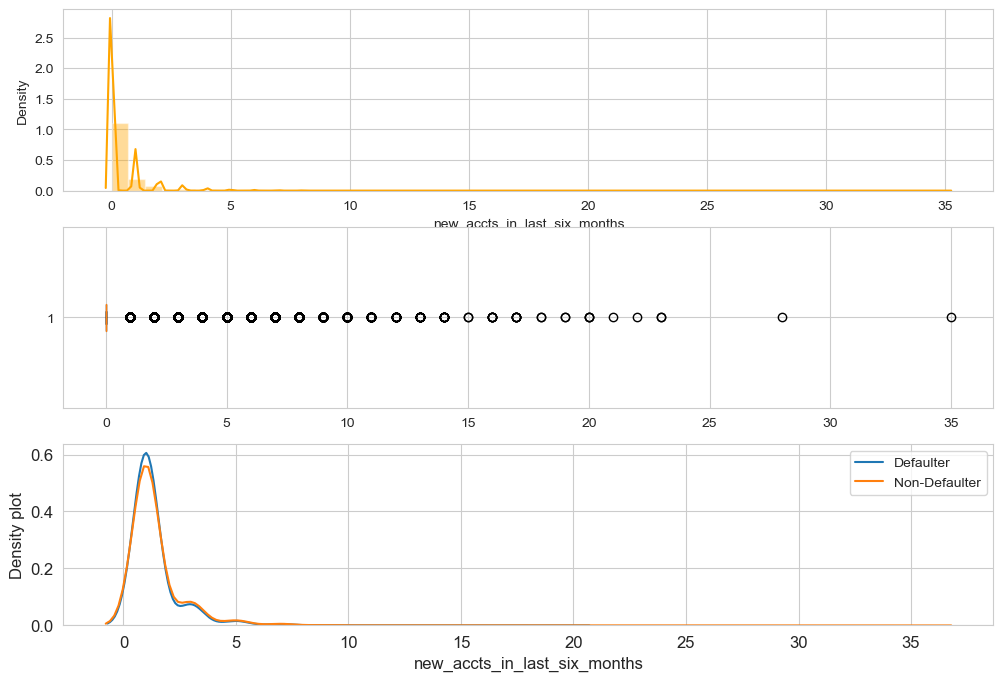

<Figure size 640x480 with 0 Axes>

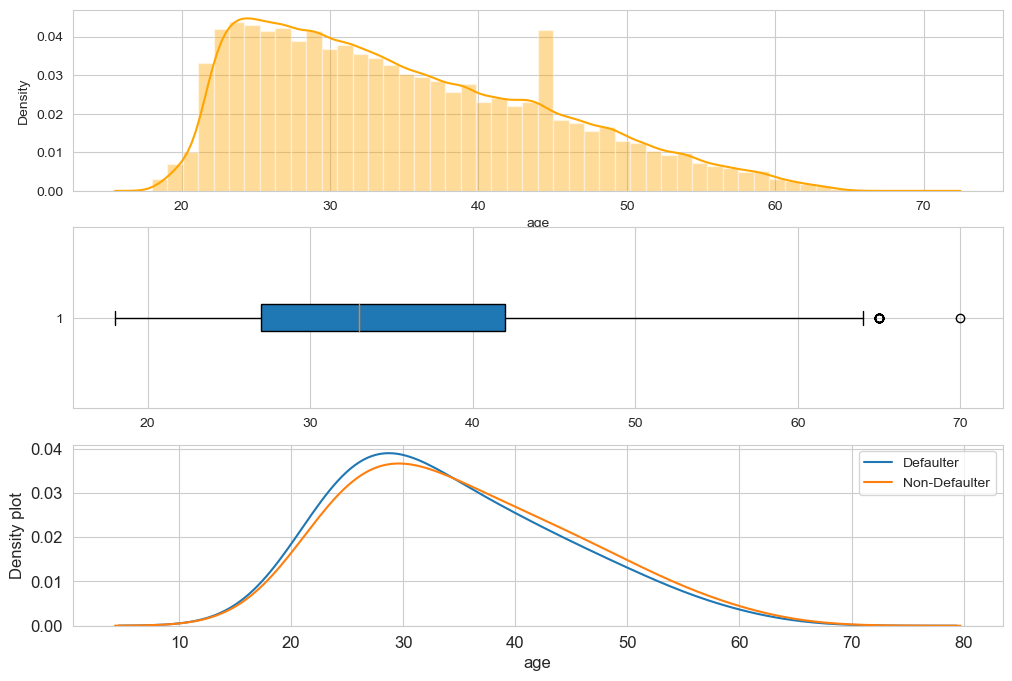

<Figure size 640x480 with 0 Axes>

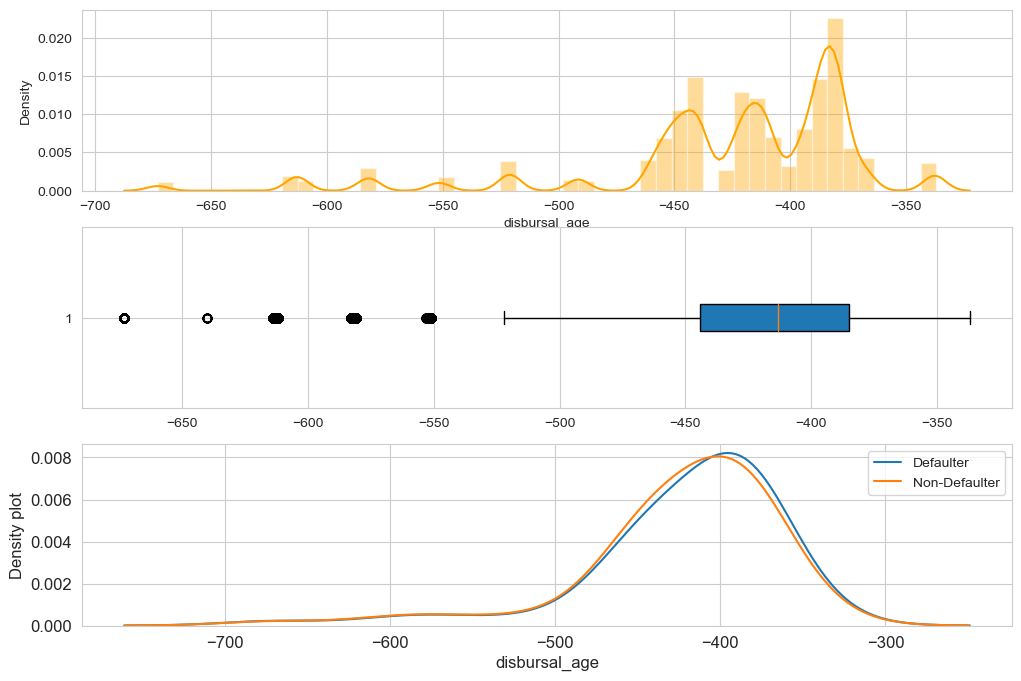

<Figure size 640x480 with 0 Axes>

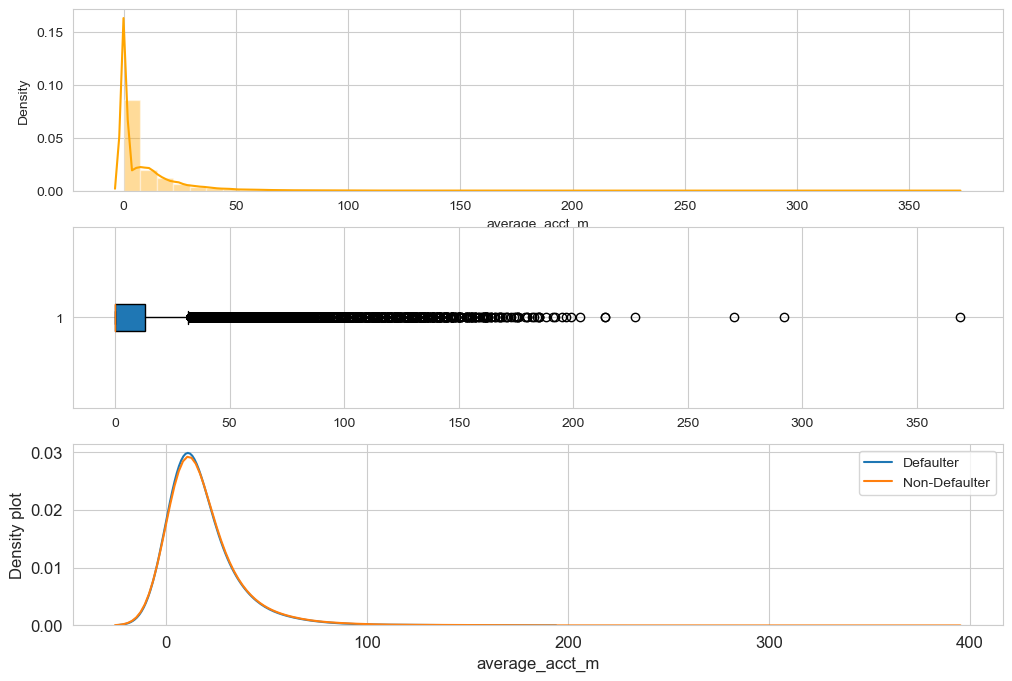

<Figure size 640x480 with 0 Axes>

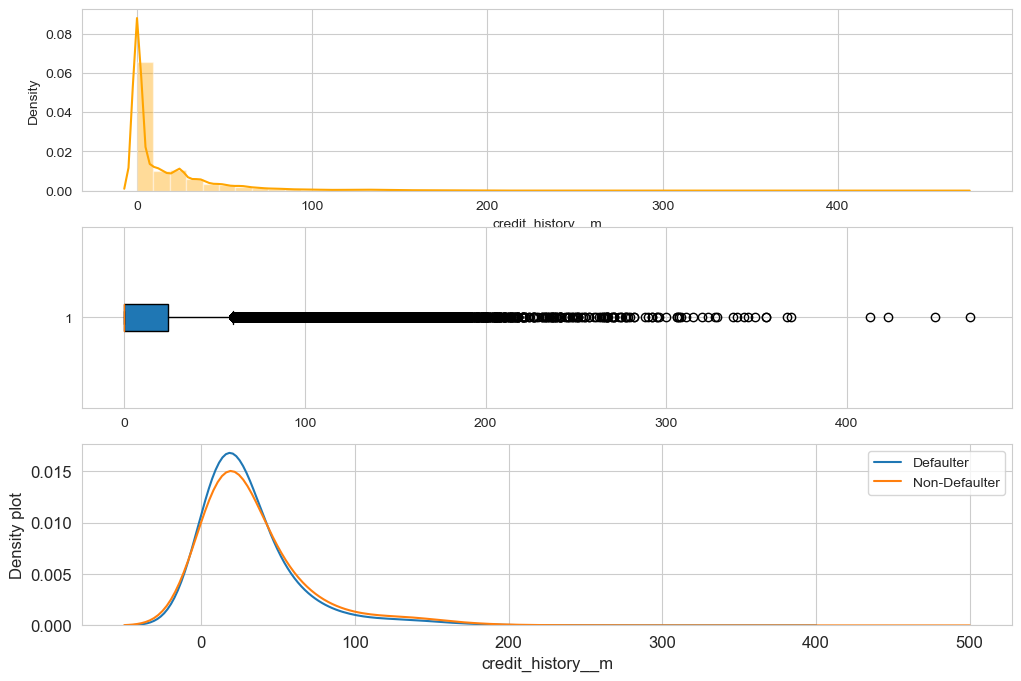

In [45]:
for col in num_cols_logit:
    plot_dist_hue(df = df_logit, col = col)

In [46]:
df_logit

,disbursed_amount,asset_cost,ltv,employment_type,state_id,perform_cns_score,pri_no_of_accts,pri_active_accts,pri_current_balance,pri_disbursed_amount,primary_instal_amt,new_accts_in_last_six_months,loan_default,age,disbursal_age,average_acct_m,credit_history__m
0,50578,58400,89.56250,Salaried,6,0,0,0,0,0,0,0,0,35,-614,0,0
1,47145,65550,73.25000,Self employed,6,598,1,1,27600,50200,1991,0,1,34,-412,23,23
2,53278,61360,89.62500,Self employed,6,0,0,0,0,0,0,0,0,34,-673,0,0
3,57513,66113,88.50000,Self employed,6,305,3,0,0,0,31,0,1,25,-382,8,15
4,52378,60300,88.37500,Self employed,6,0,0,0,0,0,0,0,1,42,-412,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,63213,105405,60.71875,Salaried,6,735,4,3,390443,416133,4084,0,0,31,-382,21,39
233150,73651,100600,74.93750,Self employed,6,825,1,0,0,0,1565,0,0,31,-385,6,6
233151,33484,71212,48.43750,Salaried,4,0,0,0,0,0,0,0,0,43,-384,0,0
233152,34259,73286,49.09375,Salaried,4,0,0,0,0,0,0,0,0,25,-409,0,0


In [47]:
for col in num_cols_logit:
    outlier_fix(df_logit, col)

Fixing: disbursed_amount
Quartile 1 = 47145.0
Quartile 3 = 60413.0
Inter Quartile Range = 13268.0
Low = 27243.0
High = 80315.0
Fixing: asset_cost
Quartile 1 = 65717.0
Quartile 3 = 79201.75
Inter Quartile Range = 13484.75
Low = 45489.875
High = 99428.875
Fixing: ltv
Quartile 1 = 68.875
Quartile 3 = 83.6875
Inter Quartile Range = 14.8125
Low = 46.65625
High = 105.90625
Fixing: perform_cns_score
Quartile 1 = 0.0
Quartile 3 = 678.0
Inter Quartile Range = 678.0
Low = -1017.0
High = 1695.0
Fixing: pri_no_of_accts
Quartile 1 = 0.0
Quartile 3 = 3.0
Inter Quartile Range = 3.0
Low = -4.5
High = 7.5
Fixing: pri_active_accts
Quartile 1 = 0.0
Quartile 3 = 1.0
Inter Quartile Range = 1.0
Low = -1.5
High = 2.5
Fixing: pri_current_balance
Quartile 1 = 0.0
Quartile 3 = 35006.5
Inter Quartile Range = 35006.5
Low = -52509.75
High = 87516.25
Fixing: pri_disbursed_amount
Quartile 1 = 0.0
Quartile 3 = 60800.0
Inter Quartile Range = 60800.0
Low = -91200.0
High = 152000.0
Fixing: primary_instal_amt
Quartile 1 

In [49]:
df_logit.drop(columns = 'new_accts_in_last_six_months', inplace=True)

num_cols_logit.remove('new_accts_in_last_six_months')

In [50]:
# transformer = ColumnTransformer([
#     ('one_hot_encoder', OneHotEncoder(), ['employment_type', 'state_id]),
#     ('standard_scaler', StandardScaler(), num_cols_logit)])

In [51]:
# transformer.fit_transform(df_logit)

In [52]:
for col in num_cols_logit:
    standard_scaler(df_logit, col) 

In [54]:
df_logit = pd.concat([df_logit, pd.get_dummies(df_logit['employment_type'], prefix='employment_type')], axis=1).drop(columns='employment_type')

In [55]:
df_logit = pd.concat([df_logit, pd.get_dummies(df_logit['state_id'], prefix='state_id')], axis=1).drop(columns='state_id')

In [56]:
df_logit

,disbursed_amount,asset_cost,ltv,perform_cns_score,pri_no_of_accts,pri_active_accts,pri_current_balance,pri_disbursed_amount,primary_instal_amt,loan_default,age,disbursal_age,average_acct_m,credit_history__m,employment_type_Salaried,employment_type_Self employed,employment_type_Unemployed,state_id_1,state_id_2,state_id_3,state_id_4,state_id_5,state_id_6,state_id_7,state_id_8,state_id_9,state_id_10,state_id_11,state_id_12,state_id_13,state_id_14,state_id_15,state_id_16,state_id_17,state_id_18,state_id_19,state_id_20,state_id_21,state_id_22
0,-0.305177,-1.242041,1.343866,-0.855453,-0.710052,-0.747606,-0.625468,-0.653003,-0.610677,0,-0.001585,-2.484709,-0.731089,-0.703927,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.610523,-0.671075,-0.154576,0.911822,-0.311677,0.299361,0.178791,0.199552,0.410546,1,-0.103466,0.186968,1.474470,0.492993,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.065028,-1.005669,1.349607,-0.855453,-0.710052,-0.747606,-0.625468,-0.653003,-0.610677,0,-0.103466,-2.484709,-0.731089,-0.703927,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.311651,-0.626117,1.246266,0.045917,0.485073,-0.747606,-0.625468,-0.653003,-0.594776,1,-1.020402,0.852116,0.036062,0.076673,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.145078,-1.090316,1.234784,-0.855453,-0.710052,-0.747606,-0.625468,-0.653003,-0.610677,1,0.711588,0.186968,-0.731089,-0.703927,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233149,0.818633,2.034333,-1.305679,1.316700,0.883448,1.869811,1.924741,1.928437,1.484086,0,-0.409112,0.852116,1.282682,1.325633,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233150,1.747033,2.034333,0.000435,1.582678,-0.311677,-0.747606,-0.625468,-0.653003,0.192042,0,-0.409112,0.785601,-0.155725,-0.391687,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233151,-1.825590,-0.218935,-2.433817,-0.855453,-0.710052,-0.747606,-0.625468,-0.653003,-0.610677,0,0.813469,0.807773,-0.731089,-0.703927,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233152,-1.756659,-0.053315,-2.373534,-0.855453,-0.710052,-0.747606,-0.625468,-0.653003,-0.610677,0,-1.020402,0.253483,-0.731089,-0.703927,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
X = df_logit.drop(columns=['loan_default'])
y = df_logit.loan_default

In [58]:
sm = SMOTE(random_state=50)
X, y = sm.fit_resample(X, y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [60]:
logit = LogisticRegression()

In [61]:
# ### Number of trees in random forest
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# lr_model = LogisticRegression()
# ### Create the random grid
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# grid_search = GridSearchCV(estimator=logit, param_grid=grid, n_jobs=3, scoring='roc_auc',error_score=0)
# grid_result = grid_search.fit(X_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

In [62]:
best_params = {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [63]:
logit = LogisticRegression(**best_params)

In [64]:
logit.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [65]:
y_pred_logit = logit.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63     55170
           1       0.63      0.61      0.62     54356

    accuracy                           0.63    109526
   macro avg       0.63      0.63      0.63    109526
weighted avg       0.63      0.63      0.63    109526



In [67]:
confusion_matrix(y_test, y_pred_logit)

array([[35482, 19688],
       [21150, 33206]], dtype=int64)

In [68]:
model_evaluation(X_train, y_train, logit)

>  0.6860201969720007
>  0.6875617051179426
>  0.687020846697415
>  0.6886495804644548
>  0.6890160968488118
Mean: 0.688, Standard Deviation: 0.001


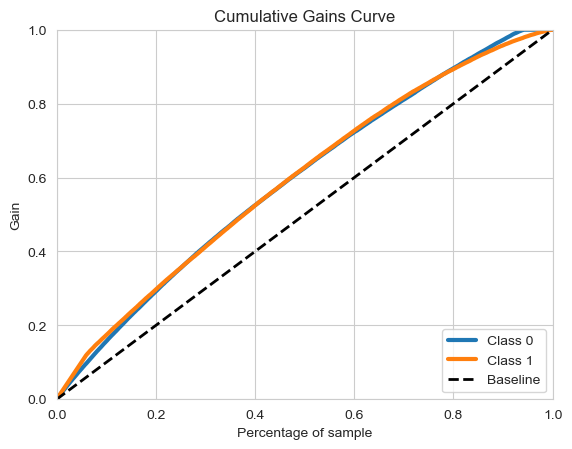

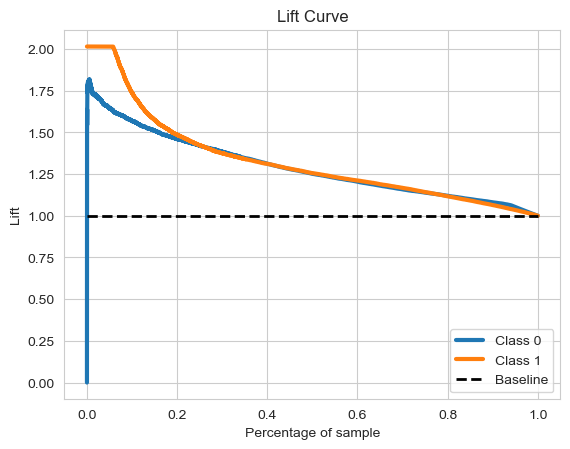

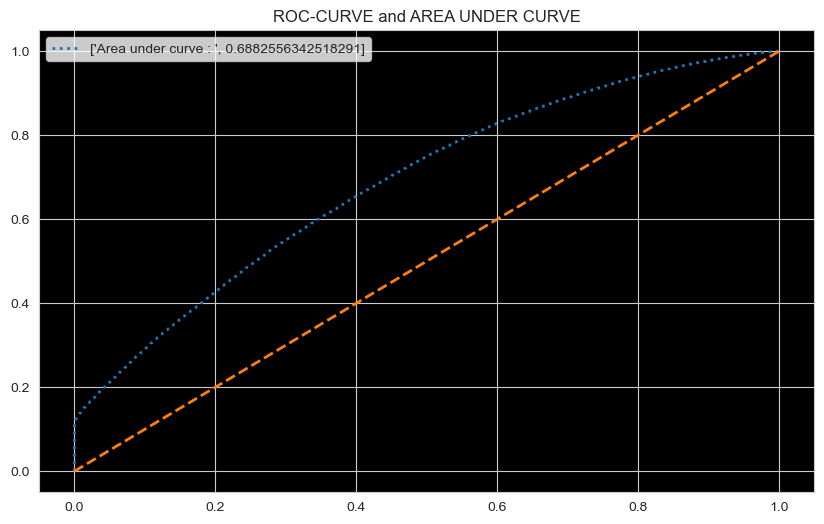

In [69]:
plot_model_evaluation(logit, X_test, y_test)

In [70]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [71]:
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     55170
           1       0.84      0.83      0.83     54356

    accuracy                           0.84    109526
   macro avg       0.84      0.84      0.84    109526
weighted avg       0.84      0.84      0.84    109526



In [72]:
confusion_matrix(y_test, y_pred_rf)

array([[46773,  8397],
       [ 9483, 44873]], dtype=int64)

In [73]:
model_evaluation(X_train, y_train, rf)

>  0.8946978071740851
>  0.8955854642892681
>  0.8982396158707562
>  0.9000061929759605
>  0.8953969723075409
Mean: 0.897, Standard Deviation: 0.002


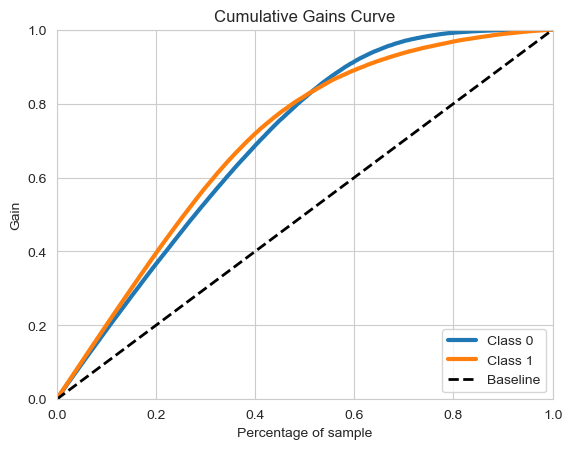

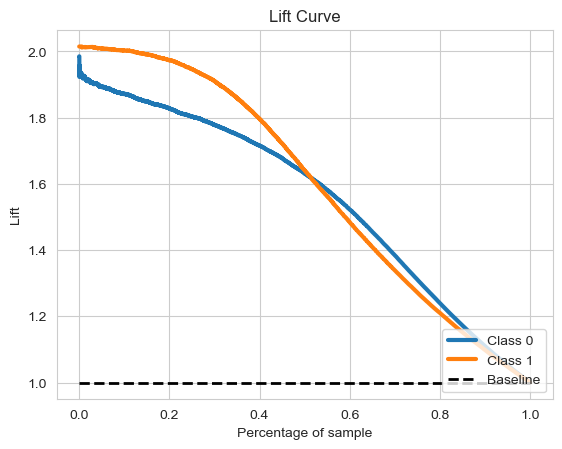

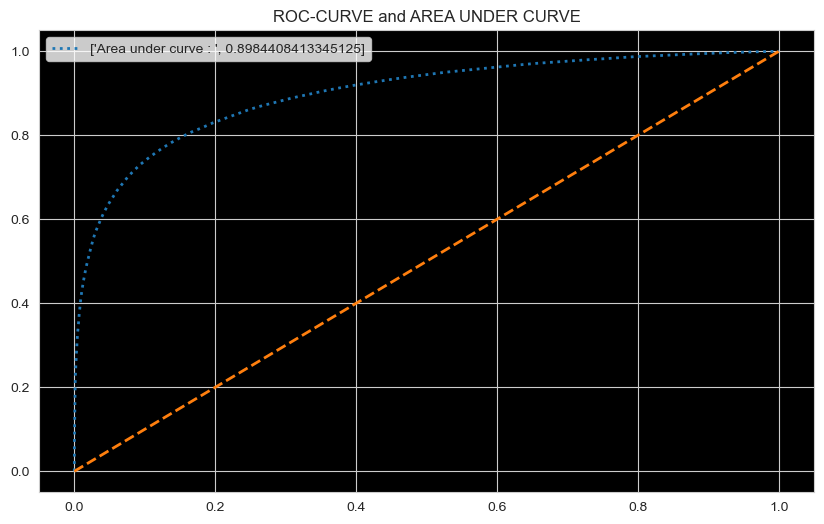

In [74]:
plot_model_evaluation(rf, X_test, y_test)

In [75]:
cb = CatBoostClassifier(verbose=False)
cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_test)

In [76]:
confusion_matrix(y_test, y_pred_cb)

array([[54544,   626],
       [15002, 39354]], dtype=int64)

In [77]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87     55170
           1       0.98      0.72      0.83     54356

    accuracy                           0.86    109526
   macro avg       0.88      0.86      0.85    109526
weighted avg       0.88      0.86      0.85    109526



In [78]:
model_evaluation(X_train, y_train, cb)

>  0.8993361602373494
>  0.9010179084565091
>  0.9044364099346318
>  0.8991792115663461
>  0.9005614114572524
Mean: 0.901, Standard Deviation: 0.002


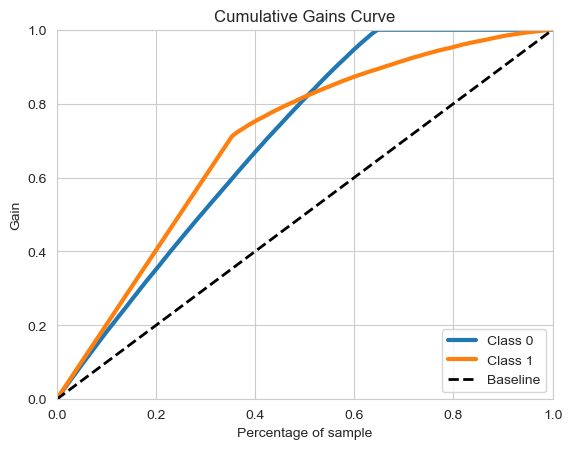

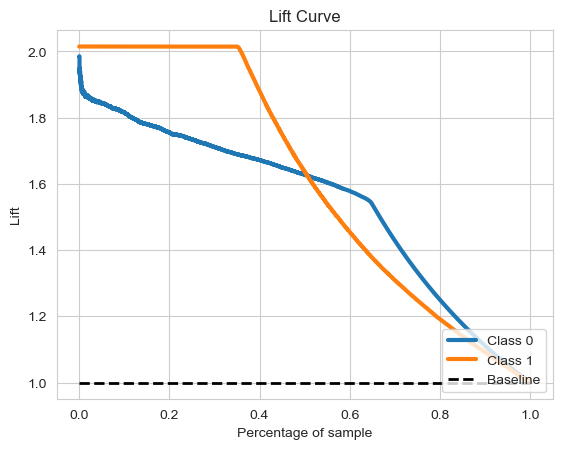

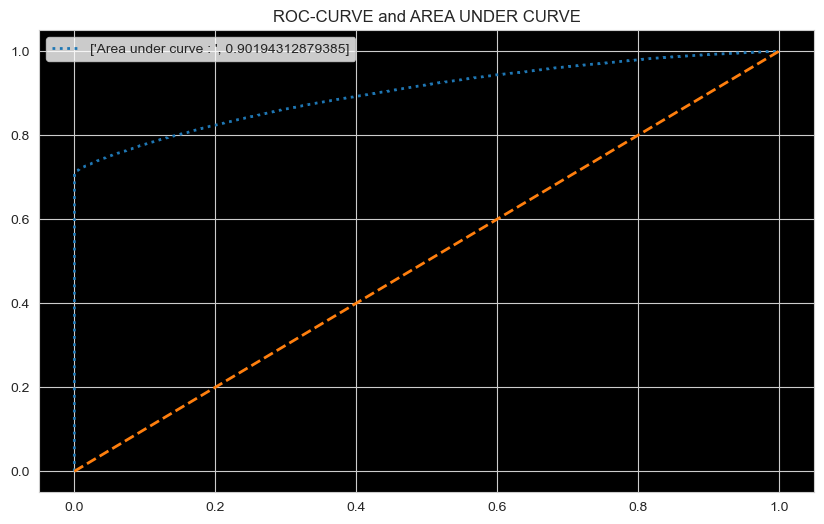

In [79]:
plot_model_evaluation(cb, X_test, y_test)

In [80]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [81]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.55      0.66     55170
           1       0.66      0.89      0.76     54356

    accuracy                           0.72    109526
   macro avg       0.75      0.72      0.71    109526
weighted avg       0.75      0.72      0.71    109526



In [82]:
confusion_matrix(y_test, y_pred_knn)

array([[30478, 24692],
       [ 6060, 48296]], dtype=int64)

In [83]:
model_evaluation(X_train, y_train, knn)

>  0.7841451477233083
>  0.7840805107444715
>  0.7834106512477053
>  0.7866989132950917
>  0.7869552090036154
Mean: 0.785, Standard Deviation: 0.001


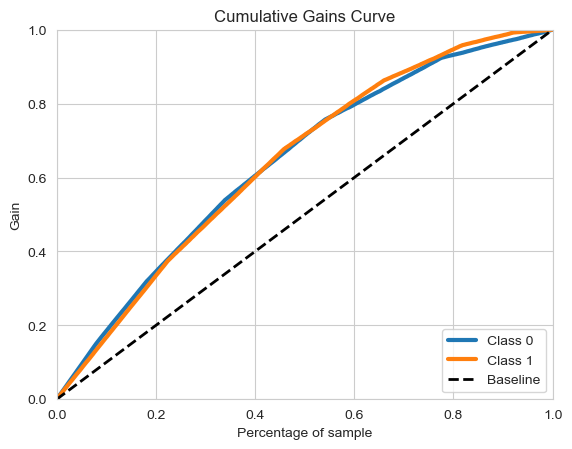

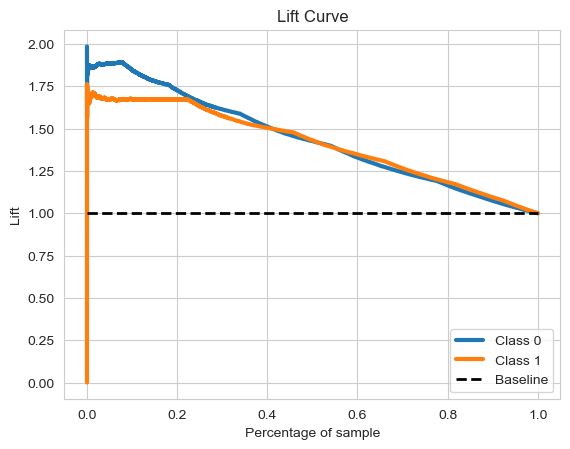

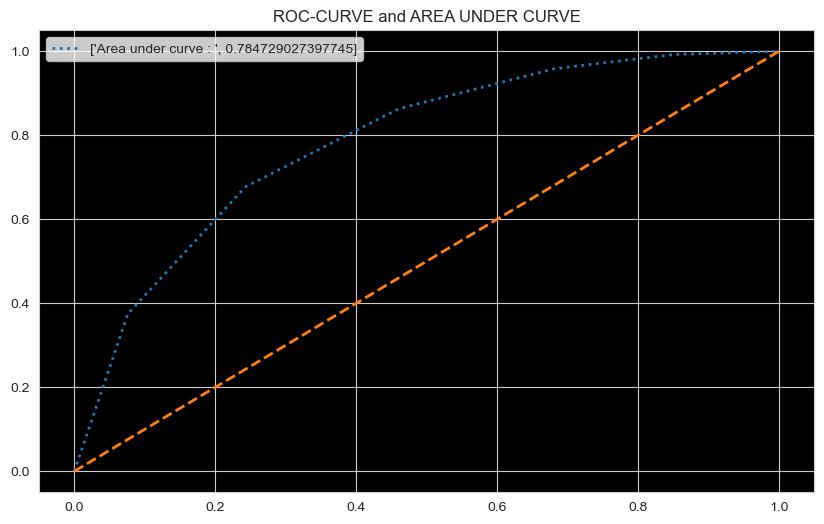

In [84]:
plot_model_evaluation(knn, X_test, y_test)

In [85]:
# eclf = VotingClassifier(estimators=[('cb', cb), ('rf', rf)], voting='hard')

# for clf, label in zip([cb, rf, eclf], ['CatBoost','Random Forest','Ensemble']):
#     scores = cross_val_score(eclf, X, y, scoring='roc_auc', cv=5)
#     print("ROC_AUC score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [86]:
eclf = VotingClassifier(estimators=[('cb', cb), ('rf', rf)], voting='hard')
eclf.fit(X_train, y_train)
y_pred_ensemble = eclf.predict(X_test)

In [87]:
confusion_matrix(y_test, y_pred_ensemble)

array([[54743,   427],
       [17958, 36398]], dtype=int64)

In [88]:
print(classification_report(y_test, y_pred_ensemble))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86     55170
           1       0.99      0.67      0.80     54356

    accuracy                           0.83    109526
   macro avg       0.87      0.83      0.83    109526
weighted avg       0.87      0.83      0.83    109526



In [147]:
df_logit.shape

(233154, 39)

In [152]:
X.shape

(365086, 38)

In [158]:
print("F1 Score ",f1_score(y_test, y_pred_ensemble))
print("Recall Score ",recall_score(y_test, y_pred_ensemble))

F1 Score  0.7983680810695211
Recall Score  0.6696224887776878


In [157]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87     55170
           1       0.98      0.72      0.83     54356

    accuracy                           0.86    109526
   macro avg       0.88      0.86      0.85    109526
weighted avg       0.88      0.86      0.85    109526

